## Comments Classifier

## Description

To build a prototype of online hate and abuse comment classifier which can be used to classify hate and offensive comments so that it can be controlled and restricted from spreading hatred and cyberbullying. 

Import required libraries

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import numpy as np
import re
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem.lancaster import LancasterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [5]:
df=pd.read_csv(r"C:\Users\teert\Downloads\Malignant-Comments-Classifier-Project--1-\Malignant Comments Classifier Project\train.csv")

In [6]:
df

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [7]:
df.tail()

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0
159570,fff46fc426af1f9a,"""\nAnd ... I really don't think you understand...",0,0,0,0,0,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   id                159571 non-null  object
 1   comment_text      159571 non-null  object
 2   malignant         159571 non-null  int64 
 3   highly_malignant  159571 non-null  int64 
 4   rude              159571 non-null  int64 
 5   threat            159571 non-null  int64 
 6   abuse             159571 non-null  int64 
 7   loathe            159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


There are no null values

## Exploratory Data Analysis

In [9]:
df.malignant.value_counts(normalize=True)

0    0.904156
1    0.095844
Name: malignant, dtype: float64

Data is imbalanced

In [10]:
df.abuse.value_counts(normalize=True)

0    0.950636
1    0.049364
Name: abuse, dtype: float64

In [11]:
df['comment_text'][0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [12]:
df['comment_text'][159570]

'"\nAnd ... I really don\'t think you understand.  I came here and my idea was bad right away.  What kind of community goes ""you have bad ideas"" go away, instead of helping rewrite them.   "'


The comments are dirty with '\n' values,numbers that will not be useful for analysis. We will be removing these further down the pipeline.

In [13]:
# Creating new subset of data by only taking the categories column
data_count=df.iloc[:,2:].sum()

In [14]:
data_count

malignant           15294
highly_malignant     1595
rude                 8449
threat                478
abuse                7877
loathe               1405
dtype: int64

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


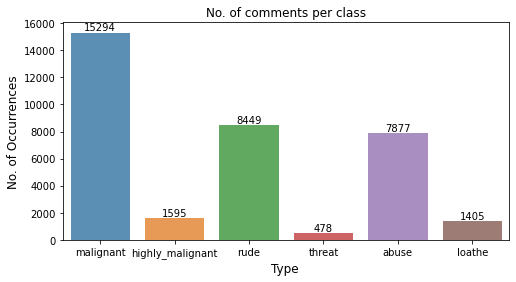

In [15]:
plt.figure(figsize=(8,4))
ax = sns.barplot(data_count.index, data_count.values, alpha=0.8)

plt.title("No. of comments per class")
plt.ylabel('No. of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)

rects = ax.patches
labels = data_count.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

In [16]:
num_rows = len(df)
print(num_rows)

159571


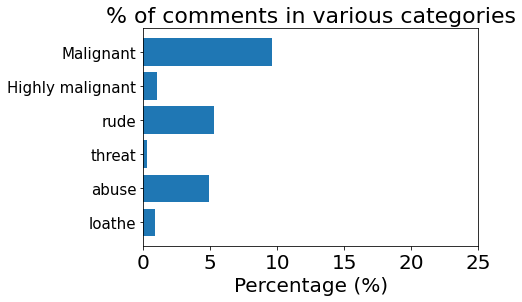

In [17]:
sum_mal = df['malignant'].sum() / num_rows * 100
sum_hgm = df['highly_malignant'].sum() / num_rows * 100
sum_rud = df['rude'].sum() / num_rows * 100
sum_thr = df['threat'].sum() / num_rows * 100
sum_abu = df['abuse'].sum() / num_rows * 100
sum_loa = df['loathe'].sum() / num_rows * 100


ind = np.arange(6)

ax = plt.barh(ind, [sum_mal, sum_hgm, sum_rud, sum_thr, sum_abu, sum_loa])
plt.xlabel('Percentage (%)', size=20)
plt.xticks(np.arange(0, 30, 5), size=20)
plt.title('% of comments in various categories', size=22)
plt.yticks(ind, ('Malignant', 'Highly malignant', 'rude', 'threat', 'abuse', 'loathe', ), size=15)


plt.gca().invert_yaxis()
plt.show()

## Preprocess the text

In [18]:
import re
import string

alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())
remove_n = lambda x: re.sub("\n", " ", x)
remove_non_ascii = lambda x: re.sub(r'[^\x00-\x7f]',r' ', x)
df['comment_text'] = df['comment_text'].map(alphanumeric).map(punc_lower).map(remove_n).map(remove_non_ascii)

In [19]:
df['comment_text']

0         explanation why the edits made under my userna...
1         d aww  he matches this background colour i m s...
2         hey man  i m really not trying to edit war  it...
3           more i can t make any real suggestions on im...
4         you  sir  are my hero  any chance you remember...
                                ...                        
159566          and for the second time of asking  when ...
159567    you should be ashamed of yourself   that is a ...
159568    spitzer   umm  theres no actual article for pr...
159569    and it looks like it was actually you who put ...
159570      and     i really don t think you understand ...
Name: comment_text, Length: 159571, dtype: object

Converted to lower case and removed all letters and unwanted charaters

### Separating dataset into 6 sections. Each section is comment and one category

In [20]:
df_mal = df.loc[:,['id','comment_text','malignant']]

In [21]:
df_hgh = df.loc[:,['id','comment_text','highly_malignant']]

In [22]:
df_rud = df.loc[:,['id','comment_text','rude']]

In [23]:
df_thr = df.loc[:,['id','comment_text','threat']]

In [24]:
df_abu = df.loc[:,['id','comment_text','abuse']]

In [25]:
df_loa = df.loc[:,['id','comment_text','loathe']]

## Word Cloud

In [26]:
import wordcloud
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [27]:
def wordcloud(dg, label):
    
    
    subset=dg[dg[label]==1]
    text=subset.comment_text.values
    wc= WordCloud(background_color="black",max_words=4000)

    wc.generate(" ".join(text))

    plt.figure(figsize=(20,20))
    plt.subplot(221)
    plt.axis("off")
    plt.title("Words frequented in {}".format(label), fontsize=20)
    plt.imshow(wc.recolor(colormap= 'gist_earth' , random_state=244), alpha=0.98)

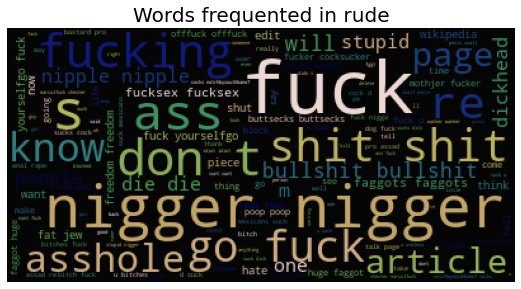

In [28]:
wordcloud(df_rud,'rude')

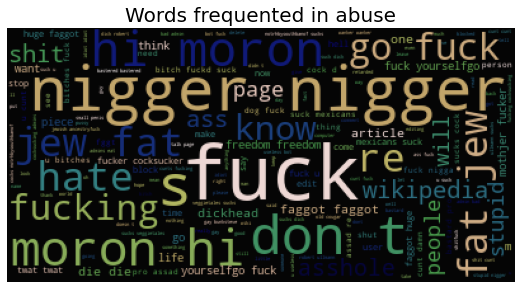

In [29]:
wordcloud(df_abu,'abuse')

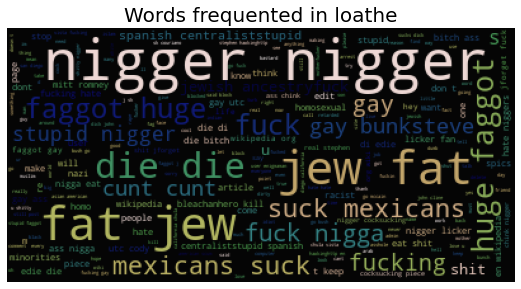

In [30]:
wordcloud(df_loa,'loathe')

### Dealing with imbalanced class

In [31]:
df_mal.head()

,id,comment_text,malignant
0,0000997932d777bf,explanation why the edits made under my userna...,0
1,000103f0d9cfb60f,d aww he matches this background colour i m s...,0
2,000113f07ec002fd,hey man i m really not trying to edit war it...,0
3,0001b41b1c6bb37e,more i can t make any real suggestions on im...,0
4,0001d958c54c6e35,you sir are my hero any chance you remember...,0


In [32]:
df_mal_1 = df_mal[df_mal['malignant'] == 1].iloc[0:5000,:]
df_mal_1.shape

(5000, 3)

In [33]:
df_mal_0 = df_mal[df_mal['malignant'] == 0].iloc[0:5000,:]

In [34]:
df_mal_0.shape

(5000, 3)

In [35]:
df_mal_final = pd.concat([df_mal_1, df_mal_0], axis=0)
df_mal_final.shape

(10000, 3)

In [36]:
df_mal_final

,id,comment_text,malignant
6,0002bcb3da6cb337,cocksucker before you piss around on my work,1
12,0005c987bdfc9d4b,hey what is it talk what is it a...,1
16,0007e25b2121310b,bye don t look come or think of comming ba...,1
42,001810bf8c45bf5f,you are gay or antisemmitian archangel whit...,1
43,00190820581d90ce,fuck your filthy mother in the ass dry,1
...,...,...,...
5544,0ece9249484eddb9,electronic intifada is not an activist site w...,0
5545,0ece971b58a3def7,new genre the new genre supernatural was use...,0
5547,0ecf7cde3391615b,translated as the second vatican council a ...,0
5549,0ed11396420e8531,purpose this rfc will be used to determine com...,0


In [37]:
df_hgh[df_hgh['highly_malignant'] == 1].count()

id                  1595
comment_text        1595
highly_malignant    1595
dtype: int64

In [38]:
df_hgh_1 = df_hgh[df_hgh['highly_malignant'] == 1].iloc[0:1595,:]
df_hgh_0 = df_hgh[df_hgh['highly_malignant'] == 0].iloc[0:1595,:]
df_hgh_final = pd.concat([df_hgh_1, df_hgh_0], axis=0)
df_hgh_final.shape

(3190, 3)

In [39]:
df_hgh_final

,id,comment_text,highly_malignant
6,0002bcb3da6cb337,cocksucker before you piss around on my work,1
55,0020e7119b96eeeb,stupid peace of shit stop deleting my stuff as...,1
181,006e87872c8b370c,you are a stupid fuck and your mother s cunt...,1
442,01208d2b76624130,hi im a fucking bitch,1
579,018663f910e0bfe6,what a motherfucking piece of crap those fuckh...,1
...,...,...,...
1607,044df95de9cc9daa,can you offer advice on how to get the kanji,0
1608,044f008b0f522099,re from coupon to groupon please don t post ...,0
1609,044f39de7fce756e,you have no friends in real life what makes y...,0
1610,044f7f9bbf278968,there are plenty of video game articles tha...,0


In [40]:
df_rud[df_rud['rude'] == 1].count()

id              8449
comment_text    8449
rude            8449
dtype: int64

In [41]:
df_rud_1 = df_rud[df_rud['rude'] == 1].iloc[0:5000,:]
df_rud_0 = df_rud[df_rud['rude'] == 0].iloc[0:5000,:]
df_rud_final = pd.concat([df_rud_1, df_rud_0], axis=0)
df_rud_final.shape

(10000, 3)

In [42]:
df_rud_final

,id,comment_text,rude
6,0002bcb3da6cb337,cocksucker before you piss around on my work,1
42,001810bf8c45bf5f,you are gay or antisemmitian archangel whit...,1
43,00190820581d90ce,fuck your filthy mother in the ass dry,1
51,001dc38a83d420cf,get fucked up get fuckeeed up got a drink t...,1
55,0020e7119b96eeeb,stupid peace of shit stop deleting my stuff as...,1
...,...,...,...
5274,0e082f20da33edfe,what does copyright mean when we are talking o...,0
5276,0e0938d05dcd9eb9,dysphoria i am afraid that the ip persists i...,0
5277,0e0a25d958600186,redirect talk the lamp film,0
5278,0e0a2b840183541c,yes probably this is why your non notable lin...,0


In [43]:
df_thr[df_thr['threat'] == 1].count()

id              478
comment_text    478
threat          478
dtype: int64

In [44]:
df_thr_1 = df_thr[df_thr['threat'] == 1].iloc[0:478,:]

# lets include 1912 comments that have no threat so that the data with threat (478) will represent 20% of the dataset.
df_thr_0 = df_thr[df_thr['threat'] == 0].iloc[0:1912,:]  
df_thr_final = pd.concat([df_thr_1, df_thr_0], axis=0)
df_thr_final.shape

(2390, 3)

In [45]:
df_thr_final

,id,comment_text,threat
79,003217c3eb469ba9,hi i am back again last warning stop undoin...,1
176,006b94add72ed61c,i think that your a fagget get a oife and burn...,1
600,0199d6af27b715f3,i m also a sock puppet of this account supri...,1
802,02230885017a50c5,fuck you smith please have me notified when ...,1
1017,02c6e41e4b317ac3,wouldn t be the first time bitch fuck you i l...,1
...,...,...,...
1916,053378b5c8d76936,no it wasn t scrapped alicia s version rema...,0
1917,053391f22acedcd3,conflict of interest your one and only qui...,0
1918,0533c68b6e61e5ee,arji what makes you think this assertion is m...,0
1919,05342a65eab40629,firstly some of the examples you used were...,0


In [46]:
df_abu[df_abu['abuse'] == 1].count()

id              7877
comment_text    7877
abuse           7877
dtype: int64

In [47]:
df_abu_1 = df_abu[df_abu['abuse'] == 1].iloc[0:5000,:]
df_abu_0 = df_abu[df_abu['abuse'] == 0].iloc[0:5000,:]
df_abu_final = pd.concat([df_abu_1, df_abu_0], axis=0)
df_abu_final.shape

(10000, 3)

In [48]:
df_abu_final

,id,comment_text,abuse
6,0002bcb3da6cb337,cocksucker before you piss around on my work,1
42,001810bf8c45bf5f,you are gay or antisemmitian archangel whit...,1
43,00190820581d90ce,fuck your filthy mother in the ass dry,1
55,0020e7119b96eeeb,stupid peace of shit stop deleting my stuff as...,1
56,0020fd96ed3b8c8b,tony sidaway is obviously a fistfuckee he lo...,1
...,...,...,...
5274,0e082f20da33edfe,what does copyright mean when we are talking o...,0
5276,0e0938d05dcd9eb9,dysphoria i am afraid that the ip persists i...,0
5277,0e0a25d958600186,redirect talk the lamp film,0
5278,0e0a2b840183541c,yes probably this is why your non notable lin...,0


In [49]:
df_loa[df_loa['loathe'] == 1].count()

id              1405
comment_text    1405
loathe          1405
dtype: int64

In [50]:
df_loa_1 = df_loa[df_loa['loathe'] == 1].iloc[0:1405,:]
df_loa_0 = df_loa[df_loa['loathe'] == 0].iloc[0:5620,:]
df_loa_final = pd.concat([df_loa_1, df_loa_0], axis=0)
df_loa_final.shape

(7025, 3)

In [51]:
df_loa_final

,id,comment_text,loathe
42,001810bf8c45bf5f,you are gay or antisemmitian archangel whit...,1
105,00472b8e2d38d1ea,a pair of jew hating weiner nazi schmucks,1
176,006b94add72ed61c,i think that your a fagget get a oife and burn...,1
218,008e0818dde894fb,kill all niggers i have hard that others h...,1
238,0097dd5c29bf7a15,u r a tw fuck off u gay boy u r smelly fuck u...,1
...,...,...,...
5667,0f27bdce24c9bdf3,entire last paragraph is supported by blogs w...,0
5668,0f2816129f07f0a5,sorry but wikipedia takes copyright very seri...,0
5669,0f288964dbc01e4e,great working together here,0
5670,0f2919193d27d4b0,template nn warn,0


## Importing packages for Modelling

In [52]:
from sklearn import preprocessing
from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve, fbeta_score, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

In [53]:
def cv_tf_train_test(df_final,label,vectorizer,ngram):

    x = df_final.comment_text
    y = df_final[label]

    # Split our data into training and test data 
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
    
    cv1 = vectorizer(ngram_range=(ngram), stop_words='english')
    
    x_train_cv1 = cv1.fit_transform(x_train) 
    x_test_cv1  = cv1.transform(x_test)     
    
    lr = LogisticRegression()
    lr.fit(x_train_cv1, y_train)
    print('lr done')

    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(x_train_cv1, y_train)
    print('knn done')

    bnb = BernoulliNB()
    bnb.fit(x_train_cv1, y_train)
    print('bnb done')
    
    mnb = MultinomialNB()
    mnb.fit(x_train_cv1, y_train)
    print('mnb done')
    
    svm_model = LinearSVC()
    svm_model.fit(x_train_cv1, y_train)
    print('svm done')

    randomforest = RandomForestClassifier(n_estimators=100, random_state=42)
    randomforest.fit(x_train_cv1, y_train)
    print('rdf done')
    
    # Create a list of F1 score of all models 
    f1_score_data = {'F1 Score':[f1_score(lr.predict(x_test_cv1), y_test), f1_score(knn.predict(x_test_cv1), y_test), 
                                f1_score(bnb.predict(x_test_cv1), y_test), f1_score(mnb.predict(x_test_cv1), y_test),
                                f1_score(svm_model.predict(x_test_cv1), y_test), f1_score(randomforest.predict(x_test_cv1), y_test)]} 
                          
    # Creating DataFrame with the model names as column labels
    df_f1 = pd.DataFrame(f1_score_data, index=['Log Regression','KNN', 'BernoulliNB', 'MultinomialNB', 'SVM', 'Random Forest'])  

    return df_f1

In [54]:
import time

t0 = time.time()

df_mal_cv = cv_tf_train_test(df_mal_final, 'malignant', TfidfVectorizer, (1,1))
df_mal_cv.rename(columns={'F1 Score': 'F1 Score(malignant)'}, inplace=True)

t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)

df_mal_cv

lr done
knn done
bnb done
mnb done
svm done
rdf done
Time taken: 12.39051342010498 seconds


,F1 Score(malignant)
Log Regression,0.860941
KNN,0.170616
BernoulliNB,0.776521
MultinomialNB,0.874958
SVM,0.876510
Random Forest,0.835621


In [56]:
t0 = time.time()

df_hgh_cv = cv_tf_train_test(df_hgh_final, 'highly_malignant', TfidfVectorizer, (1,1))
df_hgh_cv.rename(columns={'F1 Score': 'F1 Score(highly_malignant)'}, inplace=True)

t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)
df_hgh_cv

lr done
knn done
bnb done
mnb done
svm done
rdf done
Time taken: 2.5797247886657715 seconds


,F1 Score(highly_malignant)
Log Regression,0.927879
KNN,0.837809
BernoulliNB,0.803707
MultinomialNB,0.936170
SVM,0.926004
Random Forest,0.927660


In [55]:
t0 = time.time()

df_rud_cv = cv_tf_train_test(df_rud_final, 'rude', TfidfVectorizer, (1,1))
df_rud_cv.rename(columns={'F1 Score': 'F1 Score(rude)'}, inplace=True)

t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)

df_rud_cv

lr done
knn done
bnb done
mnb done
svm done
rdf done
Time taken: 7.965613842010498 seconds


,F1 Score(rude)
Log Regression,0.908655
KNN,0.410982
BernoulliNB,0.787830
MultinomialNB,0.901399
SVM,0.921378
Random Forest,0.907370


In [57]:
t0 = time.time()

df_thr_cv = cv_tf_train_test(df_thr_final, 'threat', TfidfVectorizer, (1,1))
df_thr_cv.rename(columns={'F1 Score': 'F1 Score(threat)'}, inplace=True)

t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)

df_thr_cv

lr done
knn done
bnb done
mnb done
svm done
rdf done
Time taken: 1.68989896774292 seconds


,F1 Score(threat)
Log Regression,0.628821
KNN,0.586207
BernoulliNB,0.311828
MultinomialNB,0.504762
SVM,0.786765
Random Forest,0.800000


In [58]:
t0 = time.time()

df_abu_cv = cv_tf_train_test(df_abu_final, 'abuse', TfidfVectorizer, (1,1))
df_abu_cv.rename(columns={'F1 Score': 'F1 Score(abuse)'}, inplace=True)

t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)

df_abu_cv

lr done
knn done
bnb done
mnb done
svm done
rdf done
Time taken: 9.938315868377686 seconds


,F1 Score(abuse)
Log Regression,0.896599
KNN,0.244898
BernoulliNB,0.783762
MultinomialNB,0.897411
SVM,0.902619
Random Forest,0.882616


In [60]:
t0 = time.time()

df_loa_cv = cv_tf_train_test(df_loa_final, 'loathe', TfidfVectorizer, (1,1))
df_loa_cv.rename(columns={'F1 Score': 'F1 Score(loathe)'}, inplace=True)

t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)

df_loa_cv

lr done
knn done
bnb done
mnb done
svm done
rdf done
Time taken: 6.753833055496216 seconds


,F1 Score(loathe)
Log Regression,0.699029
KNN,0.197980
BernoulliNB,0.549206
MultinomialNB,0.485857
SVM,0.797516
Random Forest,0.769821


In [61]:
f1_all = pd.concat([df_mal_cv, df_hgh_cv, df_rud_cv, df_thr_cv, df_abu_cv, df_loa_cv], axis=1)
f1_all

,F1 Score(malignant),F1 Score(highly_malignant),F1 Score(rude),F1 Score(threat),F1 Score(abuse),F1 Score(loathe)
Log Regression,0.860941,0.927879,0.908655,0.628821,0.896599,0.699029
KNN,0.170616,0.837809,0.410982,0.586207,0.244898,0.197980
BernoulliNB,0.776521,0.803707,0.787830,0.311828,0.783762,0.549206
MultinomialNB,0.874958,0.936170,0.901399,0.504762,0.897411,0.485857
SVM,0.876510,0.926004,0.921378,0.786765,0.902619,0.797516
Random Forest,0.835621,0.927660,0.907370,0.800000,0.882616,0.769821


In [62]:
f1_all_trp = f1_all.transpose()
f1_all_trp

,Log Regression,KNN,BernoulliNB,MultinomialNB,SVM,Random Forest
F1 Score(malignant),0.860941,0.170616,0.776521,0.874958,0.876510,0.835621
F1 Score(highly_malignant),0.927879,0.837809,0.803707,0.936170,0.926004,0.927660
F1 Score(rude),0.908655,0.410982,0.787830,0.901399,0.921378,0.907370
F1 Score(threat),0.628821,0.586207,0.311828,0.504762,0.786765,0.800000
F1 Score(abuse),0.896599,0.244898,0.783762,0.897411,0.902619,0.882616
F1 Score(loathe),0.699029,0.197980,0.549206,0.485857,0.797516,0.769821


Text(0.5, 1.0, 'F1 Score of ML models')

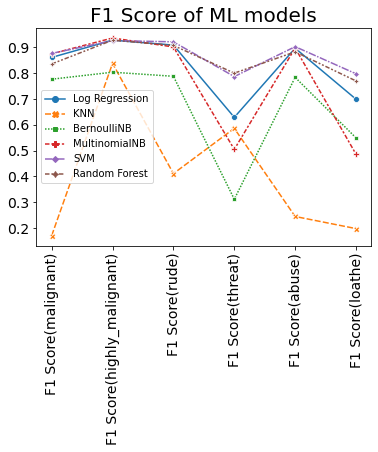

In [63]:
sns.lineplot(data=f1_all_trp, markers=True)
plt.xticks(rotation='90', fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best')
plt.title('F1 Score of ML models', fontsize=20)

LinearSVC and Random Forest models perform best (purple and brown lines seem to be the highest)

In [64]:
df_mal_final.head()

,id,comment_text,malignant
6,0002bcb3da6cb337,cocksucker before you piss around on my work,1
12,0005c987bdfc9d4b,hey what is it talk what is it a...,1
16,0007e25b2121310b,bye don t look come or think of comming ba...,1
42,001810bf8c45bf5f,you are gay or antisemmitian archangel whit...,1
43,00190820581d90ce,fuck your filthy mother in the ass dry,1


In [65]:
x = df_mal_final.comment_text
y = df_mal_final['malignant']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

tfv = TfidfVectorizer(ngram_range=(1,1), stop_words='english')

x_train_fit = tfv.fit_transform(x_train)  
x_test_fit = tfv.transform(x_test)  

randomforest = RandomForestClassifier(n_estimators=100, random_state=42)

randomforest.fit(x_train_fit, y_train)
randomforest.predict(x_test_fit)

array([0, 1, 1, ..., 1, 1, 1], dtype=int64)

## Predicting testing data

In [66]:
#Sample Prediction
dg=pd.read_csv(r"C:\Users\teert\Downloads\Malignant-Comments-Classifier-Project--1-\Malignant Comments Classifier Project\test.csv")

In [67]:
dg.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [68]:
import re
import string

alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())
remove_n = lambda x: re.sub("\n", " ", x)
remove_non_ascii = lambda x: re.sub(r'[^\x00-\x7f]',r' ', x)
dg['comment_text'] = dg['comment_text'].map(alphanumeric).map(punc_lower).map(remove_n).map(remove_non_ascii)

In [71]:
comment_vect1=dg['comment_text']

In [80]:
comment_vect1

0         yo bitch ja rule is more succesful then you ll...
1            from rfc       the title is fine as it is  ...
2                 sources         zawe ashton on lapland...
3          if you have a look back at the source  the in...
4                 i don t anonymously edit articles at all 
                                ...                        
153159        i totally agree  this stuff is nothing but...
153160       throw from out field to home plate        d...
153161            okinotorishima categories       i see ...
153162              one of the founding nations of the e...
153163           stop already  your bullshit is not welc...
Name: comment_text, Length: 153164, dtype: object

In [74]:
comment1_vect = tfv.transform(comment_vect1)
randomforest.predict_proba(comment1_vect)[:,1]

array([0.92      , 0.12258283, 0.15674026, ..., 0.12492857, 0.1803355 ,
       0.7       ])